<a href="https://colab.research.google.com/github/noshamedevil/DataScience-Projects/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook will try to predict BTC price through:
- RNN: Recurrent Neural Network
- LSTM: Long Short Term Memory
- ES: Early Stopping
- Single-Step and Multi-Step time series forecasting
- Univariate (only input Price) and Multivariate (inputs Price and Volume)

https://nbviewer.jupyter.org/github/sjuanandres0/crypto/blob/main/Main.ipynb

# Parameter settings

In [1]:
# number of total past observations from the original dataset to be considered
n_past_total = 1200

# number of past observations to be considered for the LSTM training and prediction
n_past = 30

# number of future datapoints to predict (if higher than 1, the model switch to Multi-Step)
n_future = 10

# activation function used for the RNN (softsign, relu, sigmoid)
activation = 'softsign'

# dropout for the hidden layers
dropout = 0.2

# number of hidden layers
n_layers = 8

# number of neurons of the hidden layers
n_neurons = 20

# features to be considered for training (if only one is Close, then its Univariate, if more, then it's Multivariate)
features = ['Close', 'Volume']
#features = ['Close']

# number of inputs features (if higher than 1, )
n_features = len(features)

# patience for the early stopping (number of epochs)
patience = 25

# optimizer (adam, RMSprop)
optimizer='adam'

# Importing libraries

In [2]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

# Importing the files

In [3]:
# reading csv
dataset = pd.read_csv('/content/BTC-USD.csv')
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-29,10712.463,10858.939,10665.345,10848.830,10848.830,20459870042.000
1,2020-09-30,10845.411,10856.528,10689.671,10787.618,10787.618,20759622010.000
2,2020-10-01,10785.011,10915.844,10493.553,10623.330,10623.330,27178227816.000
3,2020-10-02,10624.391,10662.813,10440.312,10585.164,10585.164,23127839259.000
4,2020-10-03,10583.807,10614.092,10527.979,10565.493,10565.493,17094010304.000
...,...,...,...,...,...,...,...
361,2021-09-25,42840.891,42996.258,41759.922,42716.594,42716.594,31604717236.000
362,2021-09-26,42721.629,43919.301,40848.461,43208.539,43208.539,30661222077.000
363,2021-09-27,43234.184,44313.246,42190.633,42235.730,42235.730,30980029059.000
364,2021-09-28,42200.898,42775.145,40931.664,41034.543,41034.543,30214940550.000


# EDA (brief)

In [4]:
# checking for nulls
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       366 non-null    object 
 1   Open       363 non-null    float64
 2   High       363 non-null    float64
 3   Low        363 non-null    float64
 4   Close      363 non-null    float64
 5   Adj Close  363 non-null    float64
 6   Volume     363 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.1+ KB


In [5]:
# checking if close is not equal to adj close
dataset[dataset['Close']!=dataset['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume
10,2020-10-09,nan,nan,nan,nan,nan,nan
13,2020-10-12,nan,nan,nan,nan,nan,nan
14,2020-10-13,nan,nan,nan,nan,nan,nan


In [6]:
# checking the main parameters
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,363.000,363.000,363.000,363.000,363.000,363.000
mean,37564.531,38705.696,36286.624,37643.309,37643.309,47145811995.410
std,14641.535,15005.155,14144.548,14578.100,14578.100,25208309072.532
min,10567.920,10614.092,10440.312,10565.493,10565.493,17094010304.000
25%,28917.792,29422.752,28462.374,29187.937,29187.937,31602104704.000
50%,38138.387,39621.836,36069.805,38152.980,38152.980,42068395846.000
75%,48905.240,49831.393,47161.549,48908.938,48908.938,58662963511.000
max,63523.754,64863.098,62208.965,63503.457,63503.457,350967941479.000


In [7]:
# use close only and fill NaN with ffil
df = dataset.set_index('Date')[features]#.tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)

In [8]:
# looking at the correlation of the main possible variables
dataset[['Close','Volume']].corr()

,Close,Volume
Close,1.000,0.367
Volume,0.367,1.000


In [9]:
# plotting Closing Price and Volume
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Scatter(x=dataset['Close'].index, y=dataset['Close'].values, name='Close'), secondary_y=False)

fig.add_trace(go.Scatter(x=dataset['Volume'].index, y=dataset['Volume'].values, name='Volume'), secondary_y=True)

# Add figure title
fig.update_layout(title_text="BTC: {}, {}".format('Close', 'Volume'))

# Set x-axis title
fig.update_xaxes(title_text='<b>Date</b>')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Close</b>', secondary_y=False)
fig.update_yaxes(title_text='<b>Volume</b>', secondary_y=True)

# Adding slider
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

We can observe a spike in volume around end of Feb2021. Let's take a look.

In [10]:
# looking at Feb21 datapoints
dataset[(dataset['Date']>'2021-02-01') & (dataset['Date']<'2021-03-01')].style.bar(subset=['Volume'], color='#d65f5f')

,Date,Open,High,Low,Close,Adj Close,Volume
126,2021-02-02,33533.199219,35896.882813,33489.218750,35510.289063,35510.289063,63088585433.000000
127,2021-02-03,35510.820313,37480.187500,35443.984375,37472.089844,37472.089844,61166818159.000000
128,2021-02-04,37475.105469,38592.175781,36317.500000,36926.066406,36926.066406,68838074392.000000
129,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402.000000
130,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653.000000
131,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143.000000
132,2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687.000000
133,2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886.000000
134,2021-02-10,46469.761719,47145.566406,43881.152344,44918.183594,44918.183594,87301089896.000000
135,2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,47909.332031,81388911810.000000


After checking from a different source, the Volume for 2021-02-26 seems to be correct (USD 350.967.941.479). Looks like that day was crazy.
https://coinmarketcap.com/historical/20210226/

# Preprocessing the data

In [11]:
# droppping firsts observations becuase they may not be representative of BTC behaviour now due to beginnings of crypto market
df = df.tail(n_past_total)

In [12]:
# train test split
training_set = df.values
print('training_set.shape:\t', training_set.shape)

training_set.shape:	 (366, 2)


In [13]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape: ', training_set_scaled.shape)
training_set_scaled

training_set_scaled.shape:  (366, 2)


array([[0.00535224, 0.01008123],
       [0.00419595, 0.01097903],
       [0.00109254, 0.03020367],
       [0.00037158, 0.01807218],
       [0.        , 0.        ],
       [0.0022467 , 0.00135615],
       [0.00450542, 0.00686241],
       [0.00106107, 0.01548773],
       [0.00214673, 0.00161851],
       [0.00676518, 0.01458069],
       [0.00676518, 0.01458069],
       [0.01380613, 0.01732381],
       [0.01546505, 0.00860989],
       [0.01546505, 0.00860989],
       [0.01546505, 0.00860989],
       [0.01632125, 0.0209942 ],
       [0.01756502, 0.02214376],
       [0.01429277, 0.02558292],
       [0.0149724 , 0.00609937],
       [0.01733853, 0.00356214],
       [0.02222496, 0.02026741],
       [0.02551745, 0.04139829],
       [0.04265741, 0.07883425],
       [0.04534361, 0.05282158],
       [0.04469469, 0.03558518],
       [0.04802922, 0.02230874],
       [0.04657679, 0.02190321],
       [0.04740936, 0.03704227],
       [0.05834613, 0.0498867 ],
       [0.05111251, 0.05622873],
       [0.

In [14]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, :])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((327, 30, 2), (327, 10))

In [15]:
# reshaping (needed to fit RNN)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape

(327, 30, 2)

In [16]:
# Building the RNN

# Initialising the RNN
regressor = Sequential()

# Input layer
regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features)))
#regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1)))

# Hidden layers
for _ in range(n_layers):
    regressor.add(Dropout(dropout))
    regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))

# Last hidden layer (changing the return_sequences)
regressor.add(Dropout(dropout))
regressor.add(LSTM(units=n_neurons, return_sequences=False, activation=activation))

# Adding the output layer
regressor.add(Dense(units=n_future))

# Compiling the RNN
regressor.compile(optimizer=optimizer, loss='mse')

# Model summary
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3960      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 20)            4080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 20)            3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 20)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 20)            3

In [17]:
# Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [18]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=32
                    , epochs=750
                    , validation_split=0.1
                    , callbacks=[early_stop]
                   )

Epoch 1/750
10/10 [==============================] - 16s 308ms/step - loss: 0.3338 - val_loss: 0.3945
Epoch 2/750
10/10 [==============================] - 1s 151ms/step - loss: 0.2579 - val_loss: 0.2645
Epoch 3/750
10/10 [==============================] - 2s 153ms/step - loss: 0.1696 - val_loss: 0.1347
Epoch 4/750
10/10 [==============================] - 1s 150ms/step - loss: 0.1094 - val_loss: 0.0601
Epoch 5/750
10/10 [==============================] - 1s 146ms/step - loss: 0.0826 - val_loss: 0.0306
Epoch 6/750
10/10 [==============================] - 1s 143ms/step - loss: 0.0671 - val_loss: 0.0272
Epoch 7/750
10/10 [==============================] - 1s 141ms/step - loss: 0.0642 - val_loss: 0.0192
Epoch 8/750
10/10 [==============================] - 1s 141ms/step - loss: 0.0638 - val_loss: 0.0232
Epoch 9/750
10/10 [==============================] - 1s 146ms/step - loss: 0.0639 - val_loss: 0.0224
Epoch 10/750
10/10 [==============================] - 1s 141ms/step - loss: 0.0612 - val_l

In [19]:
# Exporting the regressor
last_date = dataset.Date.values[-1]
params = ['reg', last_date, n_past_total, n_past, n_future, activation, n_layers, n_neurons, n_features, patience, optimizer]
modelname = 'output/'
for i in params:
    modelname += str(i)
    if i!= params[-1]:
        modelname += '_'
if not os.path.exists(modelname):
    os.makedirs(modelname)
regressor.save('{}/regressor.h5'.format(modelname))

In [20]:
list(res.history)

['loss', 'val_loss']

# Validation

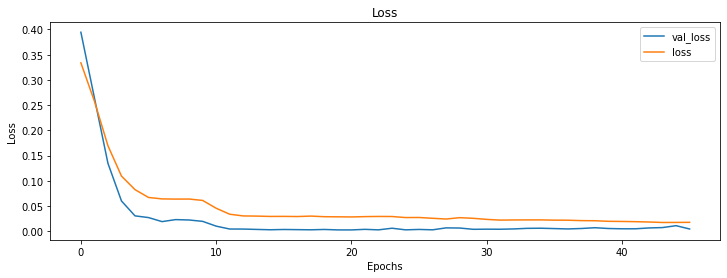

In [21]:
# Plotting Loss/MSE

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('{}/Loss.png'.format(modelname))
plt.show()

In [22]:
def dummy_invscaler(y, n_features):
    '''
    Since the scaler was trained into 2 features, it needs two features to perform the inverse scaleer.
    For that purpose, this function will create a dummy array and concatenate it to the y_pred/y_true.
    That dummy of ones will be drop after performing the inverse_transform.
    INPUTS: array 'y', shape (X,)
    '''
    y = np.array(y).reshape(-1,1)
    if n_features>1:
        dummy = np.ones((len(y), n_features-1))
        y = np.concatenate((y, dummy), axis=1)
        y = sc.inverse_transform(y)
        y = y[:,0]
    else:
        y = sc.inverse_transform(y)
    return y

y_pred:
 [47153.07516621047, 46642.5397738259, 47000.794890735364, 46990.90918378641, 46857.34643579972, 47072.35504007955, 47247.80188447238, 47026.362679885504, 47084.75555980805, 47285.41994966402]
y_true:
 [[42843.800781], [40693.675781], [43574.507813], [44895.097656], [42839.75], [42716.59375], [43208.539063], [42235.730469], [41034.542969], [41260.65625]]


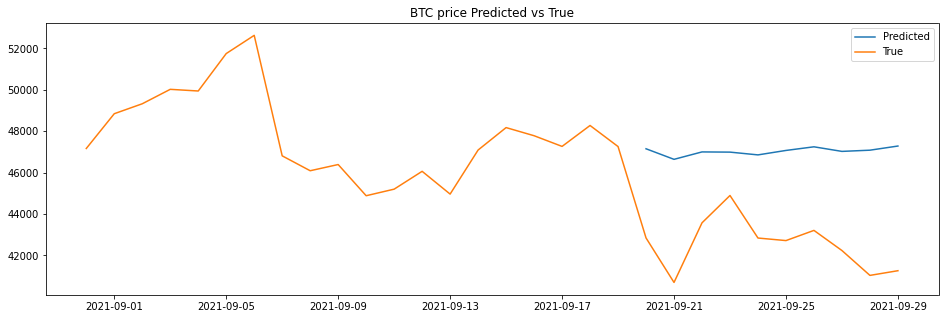

In [23]:
# Validation

# getting the predictions
y_pred = regressor.predict(X_train[-1].reshape(1, n_past, n_features)).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=df[['Close']].tail(n_future).index, 
                         columns=df[['Close']].columns)

# getting the true values
y_true_df = df[['Close']].tail(n_past)
y_true = y_true_df.tail(n_future).values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Validation.png'.format(modelname))
plt.show()

In [24]:
# Root Mean Square Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
rmse

4662.32867052507

In [25]:
# Mean Square Error (MSE)
mse = mean_absolute_error(y_true, y_pred)
mse

4505.846603226737

In [26]:
#Explained variance regression score function.
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.

0.02275700990708429

# Predictions

y_pred:
 [46553.571566633844, 46037.031545993974, 46373.76718591912, 46400.54347355679, 46289.374234097624, 46442.16883138335, 46732.70385811137, 46478.91917572886, 46601.22995085248, 46804.59531905136]
y_true:
 [[42843.800781], [40693.675781], [43574.507813], [44895.097656], [42839.75], [42716.59375], [43208.539063], [42235.730469], [41034.542969], [41260.65625]]


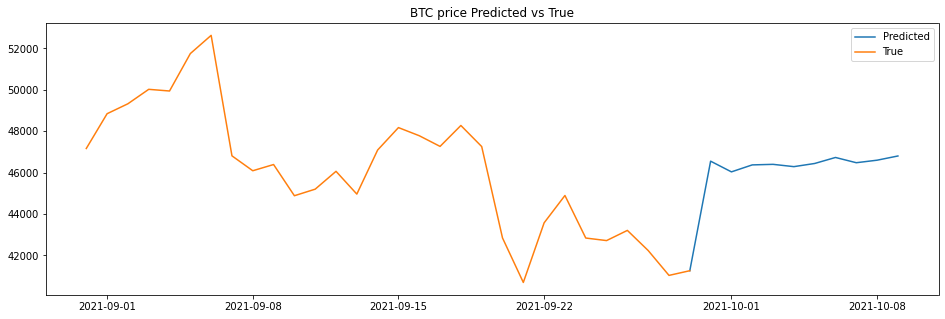

In [27]:
# Predicting/Forecasting

# getting the predictions
x = df[features][-n_past:].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df[['Close']].index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df[['Close']].columns)

# getting the true values
y_true_df = df[['Close']].tail(n_past)

# linking them
#y_true_df = y_true_df.append(y_pred_df.head(1))
y_pred_df = y_pred_df.append(y_true_df.tail(1)).sort_index()

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Predictions.png'.format(modelname))
plt.show()

In [28]:
# export to csv
y_pred_df.to_csv('{}/preds_{}.csv'.format(modelname,n_future))
# show
y_pred_df

,Close
2021-09-29,41260.656
2021-09-30,46553.572
2021-10-01,46037.032
2021-10-02,46373.767
2021-10-03,46400.543
2021-10-04,46289.374
2021-10-05,46442.169
2021-10-06,46732.704
2021-10-07,46478.919
2021-10-08,46601.230
